In [6]:
%matplotlib inline
import numpy as np
from pylab import imshow, show, cm, imsave
from scipy.stats import multivariate_normal

In [7]:
## Load the training set (preprocessed)
train_data = np.load('MNIST/train_data.npy')
train_labels = np.load('MNIST/train_labels.npy')

## Load the testing set (preprocessed)
test_data = np.load('MNIST/test_data.npy')
test_labels = np.load('MNIST/test_labels.npy')

## Print out their dimensions
print("Training dataset dimensions: ", np.shape(train_data), "\n")
print("Number of training labels: ", len(train_labels), "\n")
print("Testing dataset dimensions: ", np.shape(test_data), "\n")
print("Number of testing labels: ", len(test_labels), "\n")

## Compute the number of examples of each digit
train_digits, train_counts = np.unique(train_labels, return_counts=True)
print("Training set distribution:")
print(dict(zip(train_digits, train_counts)), "\n")

test_digits, test_counts = np.unique(test_labels, return_counts=True)
print("Test set distribution:")
print(dict(zip(test_digits, test_counts)))

Training dataset dimensions:  (60000, 784) 

Number of training labels:  60000 

Testing dataset dimensions:  (10000, 784) 

Number of testing labels:  10000 

Training set distribution:
{0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949} 

Test set distribution:
{0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


In [8]:
## Randomly sample 10000 indices to be the validation set
validation_indices = np.random.choice(len(train_labels), 10000)
validation_data = train_data[validation_indices,:]
validation_labels = train_labels[validation_indices]

## Take the remain indices to be our new training set
train_data = train_data[-validation_indices,:]
train_labels = train_labels[-validation_indices]

In [14]:
## Computes pi_j, mu_j, Cov_j for digit j
def compute_gaussian_parameters(data_i, n):
    pi_i = (np.shape(data_i)[0])/float(n)
    mu_i = np.mean(data_i, axis=0)
    cov_i = np.cov(data_i, rowvar=False)
    return(pi_i, mu_i, cov_i)

## Precompute gaussian parameters
n = len(train_labels)
gaussian_parameters = [compute_gaussian_parameters(train_data[(np.argwhere(train_labels==i)).flatten(),], n) for i in range(10)]

## Computes pi_j, Pi_j for each digit j with smoothing factor c
def compute_gaussian_models(c):
    return([(pi_j, multivariate_normal(mu_j, cov_j + c*np.identity(784))) for (pi_j, mu_j, cov_j) in gaussian_parameters])

## Given a data set and list of gaussian models, predict on each data point
def classify(data, gaussian_models):
    log_probs = np.array([(np.log(model[0]) + model[1].logpdf(data)) for model in gaussian_models])
    return(np.argmax(log_probs, axis=0))

In [15]:
val_list = []
## Validation procedure (May take awhile to )
for c in np.arange(1, 10002, 50):
    model_list = compute_gaussian_models(c)
    val_class = classify(validation_data, model_list)
    val_error = (np.sum(val_class != validation_labels))/float(len(validation_labels))
    val_list.append((c, val_error))
    print("c, error:", c, val_error)

c, error: 1 0.1443
c, error: 51 0.0856
c, error: 101 0.0712
c, error: 151 0.0656
c, error: 201 0.0614
c, error: 251 0.0589
c, error: 301 0.057
c, error: 351 0.0554
c, error: 401 0.0539
c, error: 451 0.0528
c, error: 501 0.0515
c, error: 551 0.0505
c, error: 601 0.0501
c, error: 651 0.0493
c, error: 701 0.0492
c, error: 751 0.0488
c, error: 801 0.0486
c, error: 851 0.0478
c, error: 901 0.0472
c, error: 951 0.0469
c, error: 1001 0.0465
c, error: 1051 0.0468
c, error: 1101 0.0463
c, error: 1151 0.0461
c, error: 1201 0.0461
c, error: 1251 0.0459
c, error: 1301 0.0459
c, error: 1351 0.0463
c, error: 1401 0.0464
c, error: 1451 0.0465
c, error: 1501 0.0461
c, error: 1551 0.0458
c, error: 1601 0.045
c, error: 1651 0.0449
c, error: 1701 0.0446
c, error: 1751 0.0446
c, error: 1801 0.0443
c, error: 1851 0.0438
c, error: 1901 0.0437
c, error: 1951 0.0439
c, error: 2001 0.0435
c, error: 2051 0.0433
c, error: 2101 0.0438
c, error: 2151 0.0439
c, error: 2201 0.0439
c, error: 2251 0.0438
c, error: 230

In [17]:
## Find the best c
x, y = zip(*val_list)
c = x[np.argmin(np.array(y))]
val_err = np.amin(np.array(y))
print("Best c value: ", c)
print("Validation error: ", val_err)

Best c value:  2051
Validation error:  0.0433


In [18]:
## Compute the test error with c
model_list = compute_gaussian_models(c)
test_class = classify(test_data, model_list)
test_error = (np.sum(test_class != test_labels))/float(len(test_labels))
print("Test error: ", test_error)

Test error:  0.0452


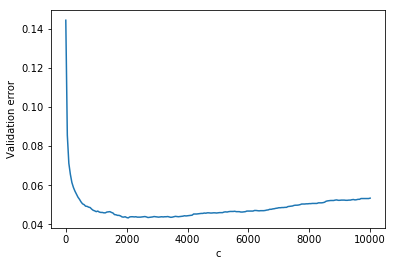

In [19]:
## Plot the validation error curve
import matplotlib.pyplot as plt
x, y = zip(*val_list)
plt.plot(x, y)
plt.ylabel("Validation error")
plt.xlabel("c")
plt.show()

### Random misclassified instances.

In [20]:
## Computes posterior probability of x
def prob_distribution(x, gaussian_models):
    log_probs = np.array([(np.log(model[0]) + model[1].logpdf(x)) for model in gaussian_models])
    max_val = np.amax(log_probs)
    log_probs = log_probs - max_val
    probs = np.exp(log_probs)
    probs = probs/np.sum(probs)
    return(probs)

## Randomly choose 5 misclassified instances
inds = np.random.choice((np.where(test_class != test_labels))[0], 5)

{0: 3.7619590254713826e-16, 1: 5.9951781456714268e-276, 2: 1.2941320867777724e-12, 3: 0.60313450675108315, 4: 8.7664681617927499e-68, 5: 4.8152655120553494e-11, 6: 1.4768673400087291e-77, 7: 4.7365630112682878e-126, 8: 0.39686549319946973, 9: 4.7609268454358725e-88} 

Predicted class:  3
True class:  8


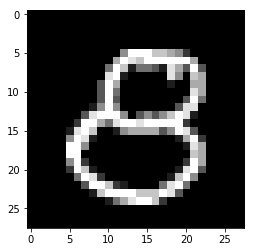

In [21]:
imshow(test_data[inds[0],].reshape((28,28)), cmap=cm.gray)

probs = prob_distribution(test_data[inds[0],], model_list)
print(dict(zip(range(10), probs)), "\n")
print("Predicted class: ", test_class[inds[0]])
print("True class: ", test_labels[inds[0]])

{0: 4.059642768217474e-36, 1: 1.764842438931942e-166, 2: 6.7207415195522889e-25, 3: 0.0014208540173753367, 4: 2.129504692582213e-64, 5: 0.99795274967508807, 6: 1.0898250233179453e-83, 7: 2.4579085008603254e-108, 8: 0.00062639630753652975, 9: 3.0497935043345697e-59} 

Predicted class:  5
True class:  3


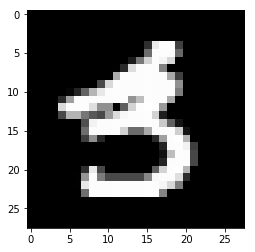

In [22]:
imshow(test_data[inds[1],].reshape((28,28)), cmap=cm.gray)

probs = prob_distribution(test_data[inds[1],], model_list)
print(dict(zip(range(10), probs)), "\n")
print("Predicted class: ", test_class[inds[1]])
print("True class: ", test_labels[inds[1]])

{0: 0.99134835759131579, 1: 4.8634025976714011e-238, 2: 0.008645328618665989, 3: 8.8349358482540963e-21, 4: 6.2860439511739367e-25, 5: 6.3137900179912853e-06, 6: 3.4615967528607873e-21, 7: 2.6290446840080096e-45, 8: 4.089189791477497e-60, 9: 2.8255738681751657e-16} 

Predicted class:  0
True class:  9


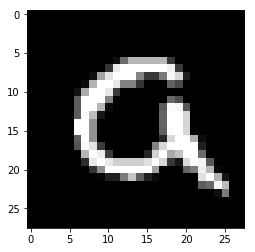

In [23]:
imshow(test_data[inds[2],].reshape((28,28)), cmap=cm.gray)

probs = prob_distribution(test_data[inds[2],], model_list)
print(dict(zip(range(10), probs)), "\n")
print("Predicted class: ", test_class[inds[2]])
print("True class: ", test_labels[inds[2]])

{0: 1.2198867241143023e-49, 1: 0.0, 2: 2.2508137804585601e-29, 3: 5.3731989392273226e-75, 4: 0.99976454317221941, 5: 4.3583769269083018e-72, 6: 0.00023545682778060507, 7: 5.126923354633385e-29, 8: 7.629868227195565e-113, 9: 2.4548505987944755e-46} 

Predicted class:  4
True class:  6


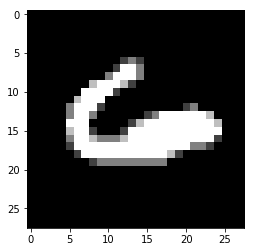

In [24]:
imshow(test_data[inds[3],].reshape((28,28)), cmap=cm.gray)

probs = prob_distribution(test_data[inds[3],], model_list)
print(dict(zip(range(10), probs)), "\n")
print("Predicted class: ", test_class[inds[3]])
print("True class: ", test_labels[inds[3]])

{0: 3.1489677115080174e-30, 1: 2.0866829922462058e-61, 2: 3.0303477609806264e-50, 3: 4.8341387475384411e-48, 4: 3.5333833598298269e-61, 5: 0.99998910049677192, 6: 6.2262932570849518e-20, 7: 5.4223491831008341e-136, 8: 1.0899503228120448e-05, 9: 8.8656833790664672e-110} 

Predicted class:  5
True class:  6


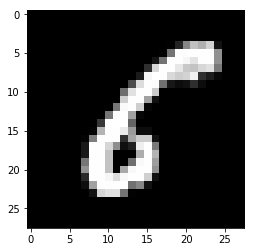

In [25]:
imshow(test_data[inds[4],].reshape((28,28)), cmap=cm.gray)

probs = prob_distribution(test_data[inds[4],], model_list)
print(dict(zip(range(10), probs)), "\n")
print("Predicted class: ", test_class[inds[4]])
print("True class: ", test_labels[inds[4]])